# Detecting AI-generated content (AIGC)

**Author:** LAM Yan Yi, Elaine (57150480), HUNG Kai Hin (57137090), WONG Hoi Fai (57151396)

**Date:** 6-Dec-2024

## Introduction
AI-generated content has been on the rise in both its popularity and its efficacy to deceive by false resemblance. Due to the rapid advancement in AI generation techniques, it has become harder and harder to differentiate between photorealistic and AI-created images. Our project aims to tackle this with our own implementation of an AI-Generated Content Detector. 

To further explain our ideas beyond basic code reading and explanation, we strive to provide a comprehensive view of our detector design and implementation, as well as, most importantly, the underlying reason for selecting such a design. The following report will delve into the importance of proper feature extraction in a well-designed network for achieving specific tasks. The report will explore our selection of feature extraction techniques and their respective crucial roles in filtering noise to ensure the fidelity of the images. Data loaders will also be discussed for their importance in effectively sampling data batches for training and validation. Our neural network model will also be introduced and thoroughly explained in the later sections. The report will also includes testing results from both our own test cases and official test results given back from TAs.

By the end of the report, readers will gain a more comprehensive understanding of the methodologies and technologies implemented in our design.

## Table of Contents

1. [Feature Extraction](#feature-extraction) <br>
    1.1 [Error Level Analysis](#error-level-analysis-ela) <br>
    1.2 [Morphological Filter](#morphological-filter-mf) <br>
    1.3 [Local Binary Pattern](#local-binary-pattern) <br>
2. [Data Loader](#data-loader) <br>
    2.1 [Data Loading](#data-loading) <br>
    2.2 [Data Sampling](#data-sampling) <br>
3. [Model](#model)
4. [Ultralytics YOLO model](#YOLO-model)
5. [Result](#result)

In [ ]:
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.transforms import v2
from torchvision import datasets, transforms

import timm
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import cv2
import numpy as np
import time
from sklearn import metrics

import zipfile
import fnmatch
from PIL import Image, ImageChops, ImageEnhance

#For texture extraction
from skimage import feature
import os
import csv

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## Feature Extraction
Feature extraction is a process to extract relevant information from raw data. Instead of putting every possible data into the model, a few selected features are used as input for the model. Unrelevant data is disregarded to reduce the drain on computational power and reduce the chances of confusing the network. The simplified data representation makes the training more efficient and quicker to complete, reducing training time.

However, choosing the suitable features to extract is no easy feat. Extracting unrelated features puts an unnecessary drain on the system and induces the possibility of confusing the training network. However, not extracting crucial features leaves the network pondering for more useful data and, therefore, unable to map useful connections between the inputs and the labels.

### Local Binary Pattern
Local binary pattern is a popular texture feature extraction technique used in the realm of machine learning and data analytics. It is able to provide a strong description of the local texture patterns within an image through comparing the central pixel with its neighbouring pixels to represent in a binary pattern. If the neighbouring pixels cross a threshold and are more intense than the centre pixel, a binary "1" is assigned. Through iterative computation of the local binary pattern for each of the pixels on the screen, the resulting output can accurately represent the local textural information stored within the image.

In [2]:
def extract_texture_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_image = gray_image.astype(np.uint8)  # Convert to integer type
    radius = 3
    n_points = 8 * radius
    lbp = feature.local_binary_pattern(gray_image, n_points, radius, method='uniform')

    lbp = lbp / lbp.max()  # Normalize the LBP values to the range [0, 1]
    
    return lbp

### Error Level Analysis (ELA)
Error level analysis is a common digital forensic technique to recognise images that have been tampered with or digitally altered. Error level analysis detects irregular distributions of quantisation noise to help identify possible regions of the image with a high concentration of inconsistencies in error level across the image.

Leveraging the ability of the error level analysis technique, we implemented it into our project as one of our feature extraction methods. It provided our system a way to highlight regions of interest that displayed a significant difference in in error levels. Due to the fact that AI-generated images often do not include natural imperfections found in real photos, it would serve a great purpose in providing information for the network to determine whether it is AI-generated or photorealistic images. 

In [3]:
def extract_color_features(image, quality=95, enhance_factor=10):
    temp_path = "temp_recompressed.jpg"
    image.save(temp_path, format="JPEG", quality=quality)
    with Image.open(temp_path) as recompressed:
        ela_image = ImageChops.difference(image, recompressed)
    os.remove(temp_path)

    enhancer = ImageEnhance.Brightness(ela_image)
    enhanced_ela = enhancer.enhance(enhance_factor)

    resized_ela = enhanced_ela.resize((224, 224)).convert("L")
    feature_array = np.array(resized_ela).astype(np.float32) / 255.0
    return feature_array

### Morphological Filter (MF)
Morphological filters are a class of image processing techniques used to analyse and process the shapes and structures within an image. There are two types of basic morphological filters as well as two advanced morphological filters that utilise the two basic ones in conjunction.

The first basic morphological filter is erosion. A morphological erosion filter is a robust technique for shrinking the boundaries of objects within an image. It decreases the amount of bright regions while increasing the amount of dark regions. By decreasing the overall amount of bright regions, it is able to erode away the brighter regions at the boundaries of the objects, effectively pushing the boundaries inward towards the centre of the object space. This process is done iteratively, resulting in an image with a greatly reduced amount of bright regions. This reduction in bright pixels is achieved through the iterative application of a minimising kernel. After applying a mask or a kernel to the image, the output pixel is calculated to be the minimum value of all the values within the masked area. The resulting output image has a strong tendency to separate overlapping objects as each boundary of the objects is shrunk inwards respectively.

The other form of basic morphological filter is dilation. A morphological dilation filter is highly capable in expanding the region of interest within an image. Reflecting a strong contrast from that of a morphological erosion filter, it increases the amount of bright regions while decreasing the amount of dark regions. By increasing the overall amount of bright areas, it is able to fill in small gaps and holes within objects in the image. On a large enough scale, it can even connect disjointed parts of the same object by enlarging and thickening the object's visual boundaries. The boundaries are seen as moving outwards, away from the centre of the object. This process is done iteratively, resulting in an image with a greatly reduced amount of dark regions. The increase in bright pixels is achieved through the iterative application of a maximising kernel. After the maximising kernel is applied, the output pixel is calculated to be the maximum value of all the values contained in the kernel area. The resulting output image will have a high likelihood of filling small gaps in the object. The added benefit of a morphological dilation filter is its ability to smooth out rough boundaries.

By combining the two basic types of morphological filters, two advanced types of morphological filters came to fruition: Opening and Closing.

Opening combines erosion and dilation, where the input image first passes through a morphological erosion filter and then passes through a morphological dilation filter. Through the specific ordered combination of erosion and dilation, it is able to break apart narrow gaps between objects. An added benefit is small objects will be covered by the filter, allowing extraction only of the important major objects.

Closing also combines both erosion and dilation. However, it encompasses both in a different order. Unlike opening, it first uses a morphological dilation filter, and then the resulting image is passed through a morphological erosion filter. Through the specific ordered combination of erosion and dilation, it is able to close small breaks.

Through careful consideration, we have decided to use opening as our method of feature extraction for our detection between AI-generated content and photorealistic images.

In [4]:
def extract_shape_features(image):
    kernel_size = 5
    transform_iteration = 5

    # Define the kernel
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    image = cv2.resize(image, (224, 224))  # Resize to (224, 224)

    image_dict = {}
    image_dict["original_image"] = image
    image_dict["eroded_image"] = cv2.erode(image_dict["original_image"], kernel, iterations=transform_iteration)
    image_dict["dilated_image"] = cv2.dilate(image_dict["original_image"], kernel, iterations=transform_iteration)
    image_dict["opened_image"] = cv2.dilate(image_dict['eroded_image'], kernel, iterations=transform_iteration)
    image_dict["closed_image"] = cv2.erode(image_dict['dilated_image'], kernel, iterations=transform_iteration)

    opened_image_resized = cv2.cvtColor(image_dict["opened_image"], cv2.COLOR_RGB2GRAY)

    return opened_image_resized  # Shape: (224, 224)


## Data Loader
### Data Loading
We implemented two data loaders, ZipImageFolderDataset and ImageFolderDataset, to handle our dataset efficiently. The ZipImageFolderDataset processes data directly from a zip file, while the ImageFolderDataset works with a pre-extracted folder. Both loaders iterate through the dataset to retrieve image file paths and assign labels based on the folder structure. Images in the "0_real" folder are labeled as photographic, and those in the "1_fake" folder are labeled as ai-generated image.

Our data loader iteratively goes through the data path, storing all of the image file paths, and their respective labels are assigned based on the folder they reside in. The image file paths are later opened to load the images as tensors. The tensors are converted to NumPy arrays to prepare for feature extraction. Before closing the image and disregarding the NumPy arrays, the arrays are passed through the three different feature extraction methods mentioned above. The three extracted feature channels are stacked and made into torch tensors to pass into the model for training. 

There is error checking to handle unforeseen cases of faulty image loading. If, for whatever reason, the image is unable to be converted to an image tensor, the system will log a critical logging message indicating what data type is received instead of the required tensor type. This not only explains to the user why the system has crashed but also provides helpful information to developers for an easier debugging process.

#### ZipImageFolderDataset
The ZipImageFolderDataset is designed to avoid extracting large zip archives, which can consume significant storage space. This loader dynamically locates image paths within the zip file and loads them on demand using Python’s zipfile module. However, processing images directly from the zip file introduces a computational overhead, making this loader slower than the folder-based approach.

In [5]:
def load_image_from_zip(zip_path, img_path):
    with zipfile.ZipFile(zip_path, 'r') as zf:
        with zf.open(img_path) as file:
            img = Image.open(file)
            return img.convert("RGB")  # Ensure the image is in RGB format
        
class ZipImageFolderDataset(datasets.ImageFolder):
    def __init__(self, zip_path, root, transform=None):
        self.zip_path = zip_path
        self.root = root
        self.transform = transform
        self.classes = ['0_real', '1_fake']
        self.img_paths = self._get_image_paths()

    def _get_image_paths(self):
        img_paths = []
        with zipfile.ZipFile(self.zip_path, 'r') as zf:
            for file_info in zf.infolist():
                name = file_info.filename
                if fnmatch.fnmatch(name, f"{self.root}/*.jpg"):
                    label = 0 if '0_real' in name.split('/')[1] else 1
                    img_paths.append((name, label))
        return img_paths

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img_path, label = self.img_paths[index]
        img = load_image_from_zip(self.zip_path, img_path)
        if self.transform:
            img_tensor = self.transform(img)
        
        # Ensure the image is now a tensor
        if not isinstance(img_tensor, torch.Tensor):
            raise TypeError(f"Expected image to be a tensor, but got {type(img_tensor)}.")
        
        # Convert tensor to numpy array for feature extraction
        img_np = img_tensor.numpy().transpose(1, 2, 0)
        
        # Extract features
        texture_features = extract_texture_features(img_np)
        color_features = extract_color_features(img)
        shape_features = extract_shape_features(img_np)
        
        features = np.stack([texture_features, color_features, shape_features], axis=0)
        features = torch.tensor(features).float().permute(1, 2, 0)  # Change the shape to [height, width, channels]
        features = features.permute(2, 0, 1)  # Change the shape to [channels, height, width]
        
        return features, label

#### ImageFolderDataset
The ImageFolderDataset operates on a pre-extracted folder structure. By accessing the unzipped files directly, this loader eliminates the need for runtime decompression, resulting in faster image loading. It is particularly efficient for scenarios where the dataset is accessed repeatedly or where speed is a critical factor.

In [6]:
class ImageFolderDataset(datasets.ImageFolder):
    def __init__(self, zip_path, root, transform=None):
        self.zip_path = zip_path
        self.root = root
        self.transform = transform
        self.classes = ['0_real', '1_fake']
        self.img_paths = self._get_image_paths()

    def _get_image_paths(roots):
        img_paths = []
        for root, dirs, files in os.walk(roots):
            for name in files:
                if fnmatch.fnmatch(name, "*.jpg"):
                    label = 0 if '0_real' in root else 1
                    img_paths.append((os.path.join(root, name), label))
        return img_paths

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img_path, label = self.img_paths[index]
        img = Image.open(img_path)
        if self.transform:
            img_tensor = self.transform(img)
        
        # Ensure the image is now a tensor
        if not isinstance(img_tensor, torch.Tensor):
            raise TypeError(f"Expected image to be a tensor, but got {type(img_tensor)}.")
        
        # Convert tensor to numpy array for feature extraction
        img_np = img_tensor.numpy().transpose(1, 2, 0)
        
        # Extract features
        texture_features = extract_texture_features(img_np)
        color_features = extract_color_features(img)
        shape_features = extract_shape_features(img_np)
        
        features = np.stack([texture_features, color_features, shape_features], axis=0)
        features = torch.tensor(features).float().permute(1, 2, 0)  # Change the shape to [height, width, channels]
        features = features.permute(2, 0, 1)  # Change the shape to [channels, height, width]
        
        return features, label

The implementation of both loaders ensures flexibility and adaptability. While the ZipImageFolderDataset reduces storage demands by working directly with compressed data, the ImageFolderDataset prioritizes speed and efficiency. By accommodating different needs, these loaders effectively handle diverse data scenarios and prepare the dataset for model training.

### Data Sampling
Not all of the data loaded is mixed together to be delivered to the network for training and validation. The training dataset is extracted and split into batches, randomising the order of the data with shuffling and then put into the network for training. The shuffling is done randomly and differently for each epoch, so the training data is different for each iteration of the training process. It gives the much-needed variety for the training data, allowing the network to have a more comprehensive view of the data. However, for the validation dataset, it is a drastically different story. For the validation dataset, we purposefully did not add random shuffling after each epoch. This is because the validating data has to be evaluated fairly between each epoch. Therefore, it is paramount that it stays the same to provide a static and unbiased view of the performance of the current epoch.

In [8]:
def load_data(zip_path, batch_size, image_size):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_dir = "AIGC-Detection-Dataset/train"
    val_dir = "AIGC-Detection-Dataset/val"
    # test_dir = "AIGC-Detection-Dataset/val"

    train_dataset = ZipImageFolderDataset(zip_path, train_dir, transform=transform)
    val_dataset = ZipImageFolderDataset(zip_path, val_dir, transform=transform)
    # test_dataset = ZipImageFolderDataset(zip_path, test_dir, transform=transform)
    print(f"Data prepared:\nTrain: {len(train_dataset)}, Val: {len(val_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    # test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    
    print("Data loaded")
    return train_loader, val_loader

## Model
The code for model training is provided below. 
We try 2 models, one is seresnext, one is yolov11 .....

### SE-ResNeXt Model
SE-ResNeXt is a neural network combining ResNext, Squeeze-and-Excitation blocks and the principle of cardinality for performing dynamic channel-wise feature recalibration. ResNeXt repeats building blocks that aggregate many transformations. 

To achieve the goal of enhancing the representational power of the network, a parameter "cardinality" is implemented to control the paths through the network. Cardinality refers to the amount of parallel pathways within any given building block in the network. Through increasing the cardinality, it greatly improves the model's ability to capture a plethora of features without significantly increasing the number of parameters, allowing the network to better grasp the convoluted connections between features. It is achieved by enabling different paths that focus on various aspects of the input data. The increased cardinality effectively utilises the computation capacity to capture a broader range of features to ultimately enhance its representational power, leading to improved performance in sophisticated relationship mapping between features and labels. The implementation of the cardinality principle distinctly separates and distinguishes SE-ResNeXt from traditional ResNet networks.

ResNeXt is a neural network architecture extended from ResNet that introduces a new block structure. It puts a strong emphasis on parallelising the model to improve the scalability of the model. The improved scalability allows for more efficient use of computational power, increasing the performance of the model. The ResNeXt network consists of many blocks, where each block is comprised of a sequence of convolutional layers and ends after batch normalisation and the ReLU activation function is applied. For each of the blocks, the input data is separated into multiple channels based on the aforementioned cardinality parameter. The outputs are condensed before passing to the next block.

For Squeeze-and-Excitation block, it is a neural network component designed to provide a more comprehensive view of the features, thereby increasing the representational power of the network. It achieves a comprehensive view through adaptive recalibration of the feature maps. The "Squeeze" operation typically uses global average pooling to greatly reduce the spatial dimensionality of the feature maps to a 1x1 matrix. On the other hand, the "Excitation" operation learns a channel-wise/feature-wise weighting that encapsulates the significance of each of the given feature channels. The channel-wise weights are learnt through a smaller neural network. The Squeeze-and-Excitation block incorporates both the squeeze and excitation operations. The input feature maps are passed through the squeeze operation to obtain a channel-wise descriptor of the features. Then, it is passed through the excitation mechanism to learn the forenamed channel-wise weightings to scale the feature maps accordingly.


(more on this part)
SE-ResNeXt combines the three factors mentioned above to achieve higher accuracy in image classification tasks. The SE blocks improve feature selection while allowing us to train our model with separated channels for various feature extraction methods.

Our architecture.....


In [ ]:
class ModifiedSEResNeXt(nn.Module):
    def __init__(self, num_classes=2):
        super(ModifiedSEResNeXt, self).__init__()
        original_model = timm.create_model('seresnext101_32x4d', pretrained=True)

        original_conv1 = original_model.conv1
        self.conv1 = nn.Conv2d(
            in_channels=3,  # 3 channels for texture, color, and shape features
            out_channels=original_conv1.out_channels,
            kernel_size=original_conv1.kernel_size,
            stride=original_conv1.stride,
            padding=original_conv1.padding,
            bias=False
        )
        
        with torch.no_grad():
            self.conv1.weight = nn.Parameter(original_conv1.weight.mean(dim=1, keepdim=True).repeat(1, 3, 1, 1))
        
        self.bn1 = original_model.bn1
        self.act1 = original_model.act1
        self.maxpool = original_model.maxpool
        self.layer1 = original_model.layer1
        self.layer2 = original_model.layer2
        self.layer3 = original_model.layer3
        self.layer4 = original_model.layer4
        self.avg_pool = original_model.global_pool
        
        num_features = original_model.fc.in_features
        self.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avg_pool(x)
        x = x.flatten(1)
        x = self.fc(x)
        
        return x


#### Get model

In [ ]:
def get_model(filename='seresnext_finetuned.pth', force_new=False):
    file_path = os.path.join(os.getcwd(), filename)

    # Use pre-existing weights
    if os.path.exists(file_path) and not force_new:
        model = ModifiedSEResNeXt()
        model.load_state_dict(torch.load(file_path, map_location=DEVICE, weights_only=True))
        print(f"Loaded model weights from {file_path}")
        return model
    
    else:   # Create a new model
        model = ModifiedSEResNeXt()
        return model

#### Model Training 
something.......

##### Validation

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs):
    model.train()
    best_val_loss = float('inf')
    patience = 3
    epochs_without_improvement = 0
    train_losses = []
    val_losses = []
    val_accuracies = []
    for epoch in range(epochs):
        running_loss = 0
        print(f"Epoch {epoch+1} started...")
        print(f"length of train_loader: {len(train_loader)}")
        start_time = time.time()
        
        batch = 1
        for features, labels in train_loader:
            # images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            features = features.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(features)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * features.size(0)
            print(f'Batch {batch} completed...')
            batch += 1
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Time: {time.time()-start_time:.2f}s')
        train_losses.append(epoch_loss)
        
        val_loss, val_accuracy = validate_model(model, val_loader, criterion)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            # Save the current best model weights (optional)
            save_model(model)
        else:
            epochs_without_improvement += 1
            
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch + 1} due to no improvement in validation loss.")
            break
    return train_losses, val_losses, val_accuracies
        

In [ ]:
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE).float().unsqueeze(1)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            predicted = (outputs > 0.5).int()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    accuracy = correct / len(val_loader.dataset)
    return val_loss, accuracy

#### Saveing result(??)

In [ ]:
def save_model(model, path='testing.pth'):
    torch.save(model.state_dict(), path)
    # for name, param in model.state_dict().items():
    #     with open(r"weights.txt",'a') as file:
    #         file.write(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")  
    # with open(r"weights.txt",'a') as file:
    #     file.write('-'*100 + '\n') 
    print("Model saved successfully!")

def save_results(train_losses, val_losses, val_accuracies, path='results.csv'):
    with open(path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Train Loss', 'Val Loss', 'Val Accuracy'])
        for i in range(len(train_losses)):
            writer.writerow([i+1, train_losses[i], val_losses[i], val_accuracies[i]])

#### Model Training Execution

#### Criterion

##### Optimizer


In [ ]:
if __name__ == '__main__':

    model_weight_filename = 'seresnext_finetuned.pth'

    model = get_model(model_weight_filename, force_new=False)
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(DEVICE)

    # Load the data
    zip_path = './AIGC-Detection-Dataset.zip'
    batch_size = 64
    image_size = 224
    train_loader, val_loader = load_data(zip_path, batch_size, image_size)

    criterion = nn.CrossEntropyLoss().to(DEVICE)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, optimizer, criterion, 5)

    # Save the results to a CSV file
    save_results(train_losses, val_losses, val_accuracies)
    
    #save the final model
    save_model(model, model_weight_filename)


#### Model Preformance Evaluation

In [13]:
def evaluate(model, test_loader):
    # Validation phase
    model.eval()
    
    y_true = []
    y_pred = []
    
    for img, label in test_loader:
        # Please make sure that the "pred" is binary result
        output = model(img.to(DEVICE))
        pred = np.argmax(output.detach().to('cpu'), axis=1).numpy()
        
        y_true.extend(label.numpy())
        y_pred.extend(pred)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracy = metrics.accuracy_score(y_true, y_pred)
    return accuracy

In [ ]:
if __name__ == '__main__':
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    #path to the model weights
    model_weight_filename = r'..\some_result\seresnent_grp3.pth'
    
    model = get_model(model_weight_filename, force_new=False)
    model = model.to(DEVICE)
    
    # Load the data
    test_dataset_path = r'..\AIGC-Detection-Dataset\AIGC-Detection-Dataset\temptest'
    
    batch_size = 16 
    image_size = 224
    test_loader= load_data(test_dataset_path, batch_size, image_size)
    
    # Evaluate the model
    accuracy = evaluate(model, test_loader)
    print(f"Accuracy: {accuracy}")
    
    

c:\CS4487\.venv\Lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Loaded model weights from c:\CS4487\nn\..\some_result\seresnent_grp3.pth
Accuracy: 0.6875


### YOLO model
We use YOLO(You Only Look Once) model for the second part. YOLO is a family of real-time object detection models. It is a one-stage object detection models that process an entire image in a single forward pass of a convolutional neural network (CNN).
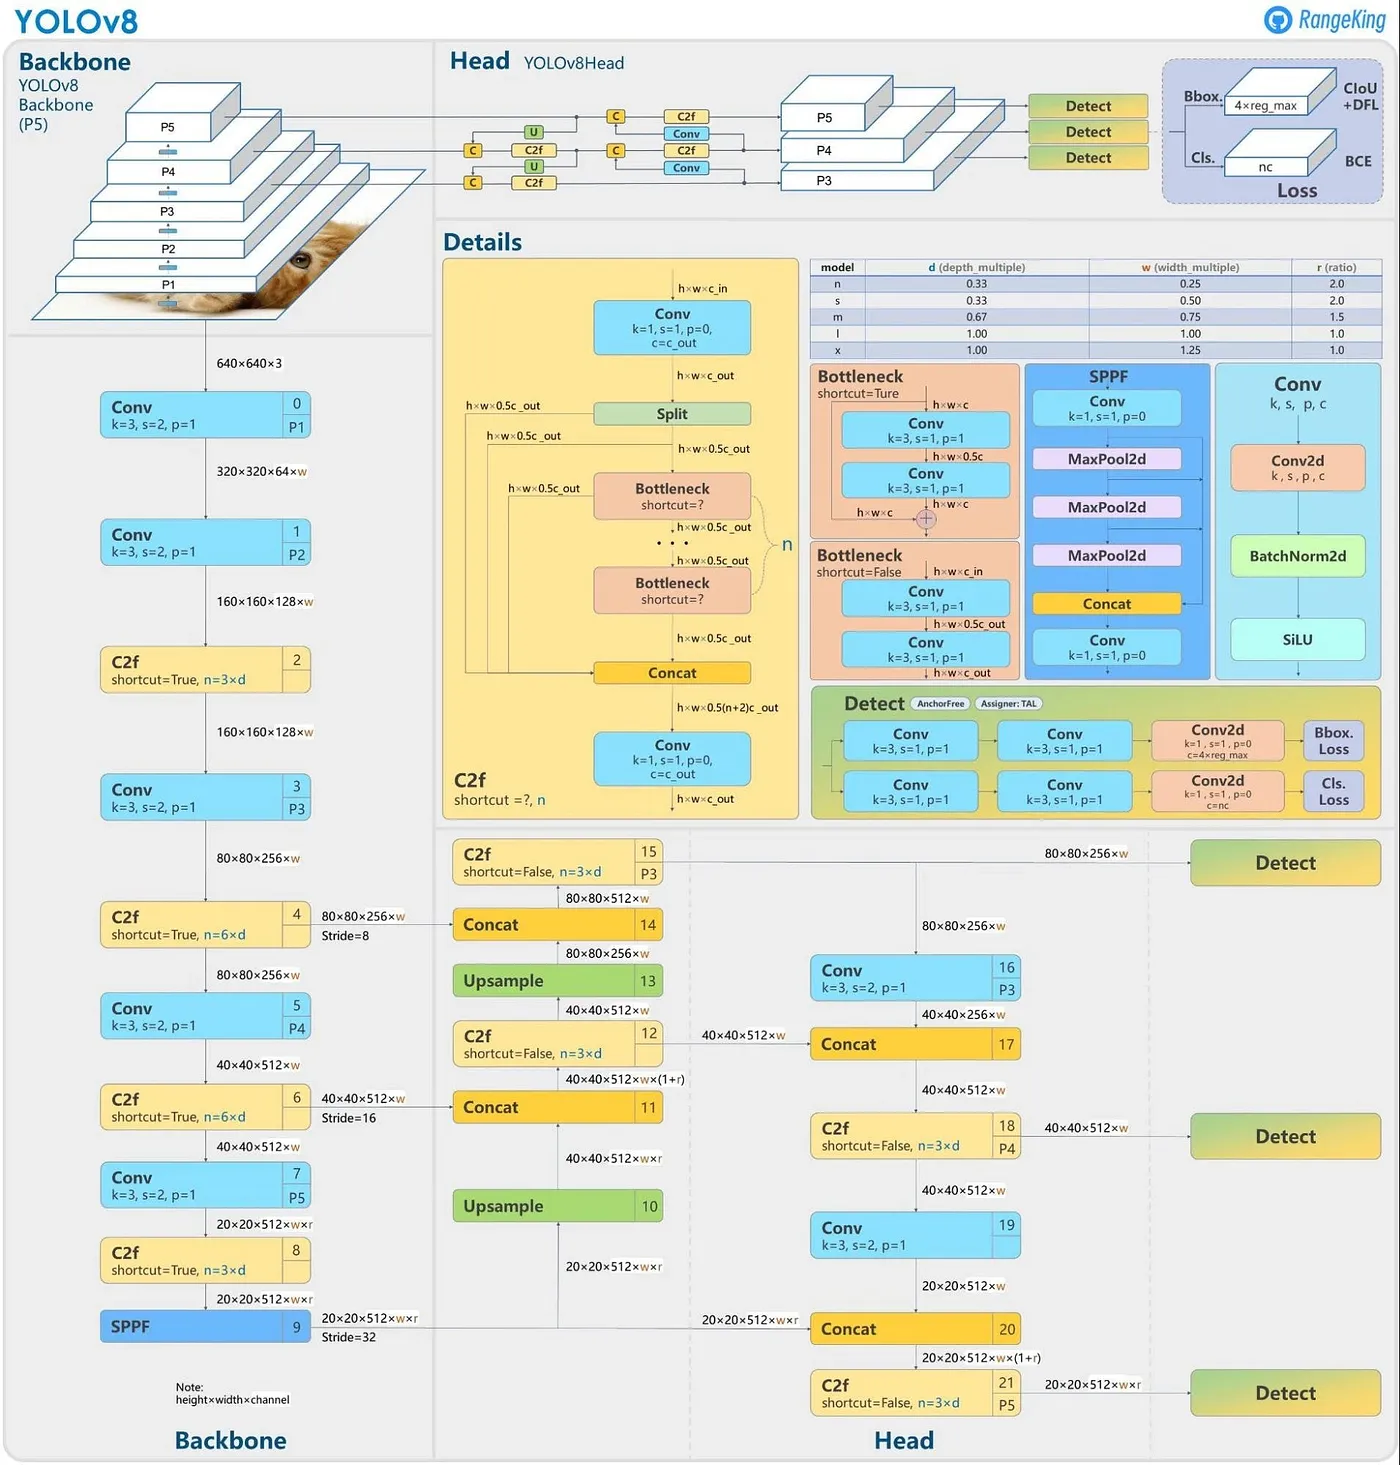
(reference: https://www.ultralytics.com/blog/introducing-ultralytics-yolov8)

YOLOv8 is the latest YOLO model. It can be used in classification, detection, segmentation, tracking and pose detection. 
In this usecase, we focus on using YOLO for classification problem: distinguish AI generated images and photos. 

In [ ]:
from ultralytics import YOLO
import torch
import os
import fnmatch
import numpy as np
from sklearn import metrics

#### YOLOv11 Model Training

#### Criterion

##### Optimizer

##### Parameter Selecion
disable all data augmentation (e.g. shift...)

In [ ]:
if __name__ == "__main__":
    # Load a model    
    model = YOLO("yolo11x-cls.pt", task='classify')
    
    data_path = 'AIGC-Detection-Dataset'
    # Train the model
    #embed to add our own feature extraction
    results = model.train(
            data=data_path, 
            epochs=40, 
            imgsz=224, 
            project='', 
            name='C:\CS4487\yololog', 
            overlap_mask=False, 
            save_period=1, 
            mask_ratio=0, 
            dropout=0.1,
            close_mosaic=40, 
            device=0, 
            rect=False,
            hsv_h=0, 
            hsv_s=0, 
            hsv_v=0, 
            translate=0,
            scale=0,
            fliplr=0, 
            erasing=0,
            mosaic=False,
            auto_augment=''
        )

#### Evaluation Function

In [ ]:
def data_loder(path):
    img_paths = []
    labels = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, "*.jpg"):
                labels.append(0 if '0_real' in root else 1)
                img_paths.append(os.path.join(root, name))
    return (img_paths, labels)

In [ ]:
def evaluate(model, test_loader, batch_size):
    # Validation phase
    model.eval()
    
    y_true = np.array(test_loader[1])
    
    img_paths = test_loader[0]
    y_pred = []

    # Process images in batches
    for i in range(0, len(img_paths), batch_size):
        j = min(i + batch_size, len(img_paths))
        batch_paths = img_paths[i:j]
        results = model.predict(batch_paths, verbose=False)  # Predict batch
        y_pred.extend([result.probs.top1 for result in results])  # Collect predictions

    y_pred = np.array(y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    return accuracy

In [ ]:
def load_model(model_path):
    model = YOLO(model_path, task='classify', verbose=False)
    model.to(DEVICE)
    print(f'Model loaded from {model_path}')
    return model

In [ ]:
if __name__ == "__main__":
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
   
    #path to the model weights
    model_weight_filename = r'epoch3.pt'
    
    model = load_model(model_weight_filename)
    
    
    # Load the data
    test_dataset_path = r'..\AIGC-Detection-Dataset\test'
    batch_size = 512
    
    test_loader = data_loder(test_dataset_path)
    
    accuracy = evaluate(model, test_loader, batch_size)
    print(f"Accuracy: {accuracy}")

Model loaded from epoch3.pt
Accuracy: 0.6896551724137931


## Result
The first submission rate (SE-ResNeXt model):<br><br>
Intra-domain Test Accuracy: 0.9224<br>
Cross-domain Test Accuracy: 0.8422<br>
Average Test Accuracy: 0.8823<br>



## Discussion

compare two models and results

## Conculsion

.....